In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"   
import MetaTrader5 as mt5
import time
from datetime import datetime, timedelta
from collections import deque
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
hour_offset = 8 # time - hour_offset = ny local time
mt5.initialize()
authorized=mt5.login(25031341, password = "!geH2e4Pi!Ka", server = "TickmillUK-Demo")
mt5.account_info()
dlen = 120
res_high = 100

In [3]:
class candle_class:
    def __init__(self, o=0,h=0,l=0,c=0,t=0):
        self.o=o
        self.h=h
        self.l=l
        self.c=c
        self.t=t
        
def get_prices(symbol, tf, lookback):
    t = int(time.time()) + 60*60*24

    prices = mt5.copy_rates_from(symbol, tf, t, lookback)
    
    candles = []
    for t,o,h,l,c,_,_,_ in prices:
        t = datetime.fromtimestamp(int(t)) - timedelta (hours=hour_offset)
        t = str(t.hour)+":"+str(t.minute)
        x = candle_class()
        x.h=h
        x.l=l
        x.o=o
        x.c=c
        x.t=t
        candles.append(x)
    
    
    return candles

In [4]:
class timeframe_manager:
    def __init__(self, candles):
        self.candles = candles
        self.current_index = 0
            
        self.d1_candles = deque(maxlen = dlen)
        self.h4_candles = deque(maxlen = dlen)
        self.h1_candles = deque(maxlen = dlen)
        self.m15_candles = deque(maxlen = dlen)
        self.m5_candles = deque(maxlen = dlen)
        
        self.last_15_open_minute = 0
        self.current_15_open_minute = 0
        
        self.last_60_open_hour = 0
        self.current_60_open_hour = 0
            
    
    def get_next_sample_candles(self):
        if len(self.candles) == self.current_index:
            return -1
        
        
        while True:
            # return dlen candles of d1, h4, h1, m15 and m5
            current_candle = self.candles[self.current_index]
            current_hour = int(current_candle.t.split(":")[0])
            open_minute = int(current_candle.t.split(":")[1])
            
            self.m5_candles.append(candle_class(current_candle.o, current_candle.h, current_candle.l, current_candle.c, str(current_hour) +":"+str(open_minute)))
            
            # m15 candles:
            self.last_15_open_minute = self.current_15_open_minute
            self.current_15_open_minute = int(open_minute/15)*15
            if self.current_15_open_minute != self.last_15_open_minute:
                self.m15_candles.append(candle_class(current_candle.o, current_candle.h, current_candle.l, current_candle.c, str(current_hour) +":"+str(open_minute)))
            else:
                if len(self.m15_candles) > 0:
                    self.m15_candles[-1].c = current_candle.c
                    self.m15_candles[-1].h = max(current_candle.h, self.m15_candles[-1].h)
                    self.m15_candles[-1].l = min(current_candle.l, self.m15_candles[-1].l)

            # h1 candles:
            self.last_60_open_hour = self.current_60_open_hour
            self.current_60_open_hour = current_hour
            if self.current_60_open_hour != self.last_60_open_hour:
                new_candle = candle_class(current_candle.o, current_candle.h, current_candle.l, current_candle.c, str(current_hour)+":00")
                self.h1_candles.append(new_candle)
            else:
                if len(self.h1_candles) > 0:
                    self.h1_candles[-1].c = current_candle.c
                    self.h1_candles[-1].h = max(current_candle.h, self.h1_candles[-1].h)
                    self.h1_candles[-1].l = min(current_candle.l, self.h1_candles[-1].l)

            # h4 candles:
            # create a new h4 candle when hour is 17, 21, 1, 5, 9, 13
            if  (current_hour == 17 or current_hour == 21 or current_hour == 1 or current_hour == 5 or current_hour == 9 or current_hour == 13) and self.current_60_open_hour != self.last_60_open_hour:
                new_candle = candle_class(current_candle.o, current_candle.h, current_candle.l, current_candle.c, str(current_hour)+":00")
                self.h4_candles.append(new_candle)
            else:
                if len(self.h4_candles) > 0:
                    self.h4_candles[-1].c = current_candle.c
                    self.h4_candles[-1].h = max(current_candle.h, self.h4_candles[-1].h)
                    self.h4_candles[-1].l = min(current_candle.l, self.h4_candles[-1].l)

            # d1 candles:
            # create a new d1 candle when hour is 17
            if  current_hour == 17 and self.current_60_open_hour != self.last_60_open_hour:
                new_candle = candle_class(current_candle.o, current_candle.h, current_candle.l, current_candle.c, str(current_hour)+":00")
                self.d1_candles.append(new_candle)
            else:
                if len(self.d1_candles) > 0:
                    self.d1_candles[-1].c = current_candle.c
                    self.d1_candles[-1].h = max(current_candle.h, self.d1_candles[-1].h)
                    self.d1_candles[-1].l = min(current_candle.l, self.d1_candles[-1].l)

            self.current_index+=1    
            if len(self.d1_candles) == dlen:
                break

        return self.m5_candles, self.m15_candles,  self.h1_candles, self.h4_candles, self.d1_candles
    
    
    
    def to_model_input(self, candles):
        def scale_p(p):
            return int((p - max_l) / hlrange * (res_high))
        max_h = 0
        max_l = 1000000
        for i in candles:
            if i.h > max_h:
                max_h = i.h
            if i.l < max_l:
                max_l = i.l
        hlrange = max_h - max_l
        
        
        def scale_time(t):
            hour = int(t.split(":")[0])
            minute = int(t.split(":")[1])
            total = hour * 60 + minute
            max_t = 24*60
            scaled = total / max_t
            return scaled
            
        
        
        image = []
        for i in candles:
            clm = np.zeros(shape = (res_high+1))
            color = 1 if i.o<i.c else -1
            high_scaled = scale_p(i.h)
            low_scaled = scale_p(i.l)
            clm[low_scaled:high_scaled] = 0.5 * color
            open_scaled = scale_p(i.o)
            close_scaled = scale_p(i.c)
            if color == 1:
                clm[open_scaled:close_scaled+1] = color
            if color == -1:
                clm[close_scaled:open_scaled+1] = color
                
            c_time = scale_time(i.t)
            clm[-1] = c_time
            image.append(clm)
        
        current_close = candles[-1].c
        scaled_close = scale_p(current_close)
        clm = np.zeros(shape = (res_high+1))
        clm[scaled_close] = 1
        image.append(clm)
        
        return np.array(image).T

In [5]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.05, **kwargs):
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate
        super(TransformerBlock, self).__init__(**kwargs)
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
    def get_config(self):
        base_config = super(TransformerBlock, self).get_config()
        base_config['embed_dim'] = self.embed_dim
        base_config['num_heads'] = self.num_heads
        base_config['ff_dim'] = self.ff_dim
        base_config['rate'] = self.rate
        return base_config
    
    
    
class PositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, embed_dim, **kwargs):
        self.maxlen = maxlen
        self.embed_dim = embed_dim
        super(PositionEmbedding, self).__init__(**kwargs)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = self.maxlen
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions
    
    def get_config(self):
        base_config = super(PositionEmbedding, self).get_config()
        base_config['maxlen'] = self.maxlen
        base_config['embed_dim'] = self.embed_dim
        return base_config

In [6]:

tf.keras.backend.clear_session()

def make_model():
    C1 = tf.keras.layers.Conv2D(64, 9,activation="relu", padding="same")

    D1 = tf.keras.layers.Dense(64)
    D2 = tf.keras.layers.Dense(512)
    D3 = tf.keras.layers.Dense(256)
    num_tx_units = 96
    D4 = tf.keras.layers.Dense(num_tx_units)
    D5 = tf.keras.layers.Dense(512)
    D6 = tf.keras.layers.Dense(256)

    LR = tf.keras.layers.LeakyReLU()

    LN1 = tf.keras.layers.LayerNormalization()

    P1 =  PositionEmbedding(dlen+1, num_tx_units)
    T1 = TransformerBlock(num_tx_units, 8, 256)
    T2= TransformerBlock(num_tx_units, 8, 256)
    T3 = TransformerBlock(num_tx_units, 8, 256)

    cn = tf.keras.layers.Concatenate()

    GR1 = tf.keras.layers.GRU(256)
    def proc_chart(x):
        #x1 = image
        #x2 = time
        x1 = x[::, :-1, :]
        x2 = x[::,-1,:]

        x1 = tf.keras.layers.Reshape((res_high, dlen+1, 1))(x1)

        x5 = C1(x1)
        x1 =cn([x1,x5])
        x1 = D1(x1)

        x1 = tf.transpose(x1,perm=[0, 2, 1, 3])
        x1 = tf.keras.layers.Reshape((dlen+1, res_high*x1.shape[-1]))(x1)
        x2 = tf.keras.layers.Reshape((dlen+1, 1))(x2)
        x1 = cn([x1,x2])

        x1 = D2(x1)
        x1 = LR(x1)
        x1 = D3(x1)
        x1 = LR(x1)
        x1 = D4(x1)
        x1 = LR(x1)
        x1 = LN1(x1)



        x1 = P1(x1)
        x1 = T1(x1)
        x1 = T2(x1)
        x1 = T3(x1)

        x1 = D5(x1)
        x1 = LR(x1)
        x1 = D6(x1)
        x1 = LR(x1)
        #x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
        x1 = GR1(x1)

        x1 = tf.keras.layers.Dense(1024,activity_regularizer=tf.keras.regularizers.L2(0.00001))(x1)
        x1 = LR(x1)
        x1 = tf.keras.layers.Dense(1024,activity_regularizer=tf.keras.regularizers.L2(0.00001))(x1)
        x1 = LR(x1)
        x1 = tf.keras.layers.Dense(1024,activity_regularizer=tf.keras.regularizers.L2(0.00001))(x1)
        x1 = LR(x1)
        x1 = tf.keras.layers.Dense(256,activity_regularizer=tf.keras.regularizers.L2(0.00001))(x1)
        x1 = LR(x1)
        #x1 = tf.keras.layers.LayerNormalization()(x1)
        return x1
    
    input_m5 = tf.keras.layers.Input(shape = (res_high+1, dlen+1))
    input_m15 = tf.keras.layers.Input(shape = (res_high+1, dlen+1))
    input_h1 = tf.keras.layers.Input(shape = (res_high+1, dlen+1))
    input_h4 = tf.keras.layers.Input(shape = (res_high+1, dlen+1))
    input_d1 = tf.keras.layers.Input(shape = (res_high+1, dlen+1))
    
    x0 = proc_chart(input_m5)
    x1 = proc_chart(input_m15)
    x2 = proc_chart(input_h1)
    x3 = proc_chart(input_h4)
    x4 = proc_chart(input_d1)
    
    input_net_position = tf.keras.layers.Input(shape = (1))


    x =cn([x0,x1,x2,x3,x4,input_net_position])
    
    x = tf.keras.layers.Dense(1024)(x)
    x = LR(x)
    x = tf.keras.layers.Dense(1024)(x)
    x = LR(x)
    x = tf.keras.layers.Dense(1024)(x)
    x = LR(x)
    
    outputs = tf.keras.layers.Dense(2, activation = "linear", use_bias=False, dtype="float32")(x)
    model = tf.keras.Model([input_m5,input_m15,input_h1,input_h4, input_d1, input_net_position], outputs)
    return model
    
model = make_model()
#model.summary()

In [7]:
entry_candles = deque(maxlen = dlen)
def plot_candles(candles, name, plot_entrys = False, was_entry = 0):
    global entry_candles
    if plot_entrys:
        if was_entry != 0:
            entry_candles.append([0,was_entry])
            
    
    def scale_p(p):
        return (p - max_l) / hlrange * h
    
    w = 300
    h = 200
    canvas = np.zeros((h,w,3), np.uint8) 
    l = dlen
    single_candle_w = w / l * 0.95
    max_h = 0
    max_l = 1000000
    for i in candles:
        if i.h > max_h:
            max_h = i.h
        if i.l < max_l:
            max_l = i.l
    hlrange = max_h - max_l
    
    for i in range(len(candles)):  
        color = (0,200,0) if candles[i].c > candles[i].o else (0,0,200)
        if plot_entrys:
            color = (0,100,0) if candles[i].c > candles[i].o else (0,0,100)
        cv2.rectangle(canvas, (int(i*single_candle_w),int(scale_p(candles[i].o))), (int((i+1)*single_candle_w),int(scale_p(candles[i].c))), color, -1)
        cv2.line(canvas, (int((i+0.5)*single_candle_w),int(scale_p(candles[i].h))), (int((i+0.5)*single_candle_w),int(scale_p(candles[i].l))), color)

    if plot_entrys:
        for i in range(len(entry_candles)):
            entry_candles[i][0]+=1
            
        if len(entry_candles) > 1 and len(candles) == dlen:
            for i in range(len(entry_candles)-1):
                entry = entry_candles[i][0]
                exit = entry_candles[i+1][0]
                position = entry_candles[i][1]
                if position == 2:continue
                startpos = dlen - entry
                endpos = dlen - exit
                if startpos > 0:
                    color = (0,255,0) if position == 1 else (0,0,255)
                    #print(startpos, endpos)
                    cv2.line(canvas, (int((startpos+0.5)*single_candle_w),int(scale_p(candles[startpos].c))), (int((endpos+0.5)*single_candle_w),int(scale_p(candles[endpos].c))), color, 2)
            
        
        
    canvas = canvas[::-1]
    
    cv2.imshow(name, canvas)
    cv2.waitKey(1)

    
def plot_outputs(outputs):
    
    def scale_p(p):
        return (p - max_l) / hlrange * h
    
    w = 300
    h = 200
    canvas = np.zeros((h,w,3), np.uint8) 
    l = dlen
    single_candle_w = w / l * 0.95
    max_h = 0
    max_l = 1000000
    for i in outputs:
        if max(i) > max_h:
            max_h = max(i)
        if min(i) < max_l:
            max_l = min(i)
    hlrange = max_h - max_l
    
    for i in range(len(outputs)-1):  
        cv2.line(canvas, (int((i+0.5)*single_candle_w),int(scale_p(outputs[i][1]))), (int((i+1+0.5)*single_candle_w),int(scale_p(outputs[i+1][1]))), (0,200,0))
        cv2.line(canvas, (int((i+0.5)*single_candle_w),int(scale_p(outputs[i][0]))), (int((i+1+0.5)*single_candle_w),int(scale_p(outputs[i+1][0]))), (0,0,200))

    canvas = canvas[::-1]
    
    cv2.imshow("outputs", canvas)
    cv2.waitKey(1)

def plot_eq(eq_list):
    if len(eq_list) < 5:
        return
    def scale_p(p):
        return int((p - max_l) / hlrange * h)
    
    w = 500
    h = 200
    canvas = np.zeros((h,w,3), np.uint8) 
    l = dlen
    single_candle_w = w / l * 0.95
    max_h = max(eq_list)
    max_l = min(eq_list)
    
    hlrange = max_h - max_l
    if hlrange == 0:
        return
    
    m = w
    nc = len(eq_list) / m
    i = 0
    num = 0
    while True:
        pos0 = eq_list[int(i)]
        pos1 = eq_list[int(i+nc)]
        cv2.line(canvas, (num, scale_p(pos0)), (num+1, scale_p(pos1)),(200,200,200))
        i+=nc
        num+=1
        if num+1 == m:
            break
            
    canvas = canvas[::-1]
    cv2.imshow("equity", canvas)
    cv2.waitKey(1)
    
        


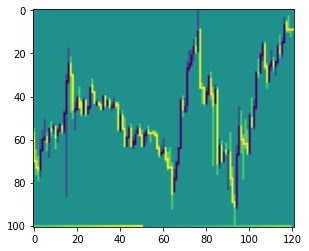

In [8]:
candles = get_prices("EURUSD", mt5.TIMEFRAME_M5, 90000)
tm = timeframe_manager(candles)
m5,m15,h1,h4,d1 = tm.get_next_sample_candles()
plt.imshow(tm.to_model_input(m15))

 -88.53471  .  -1   

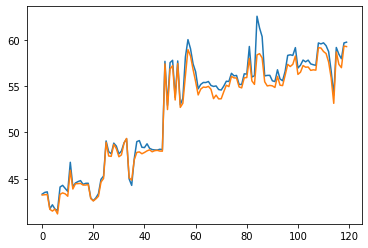

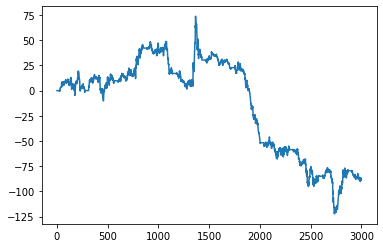

In [17]:
pos_size = 0.05 * 100000
comm = 15/100000
#comm = 0/100000
model.load_weights("dqn_trading_transformer.h5")

tm = timeframe_manager(candles)
current_position = 0
balance = 0
equity = 0
reset_entry_price = False
entry_price = 1

eq_list = []
outputs = deque(maxlen = dlen)
if True:
#try:
    #while True:
    for _ in range(3000):
    #for _ in range(5000):
        m5,m15,h1,h4,d1 = tm.get_next_sample_candles()
        if m5 == -1:
            break

        if reset_entry_price: entry_price = m5[-1].o
        current_close = m5[-1].c
        percent_change = (current_close - entry_price) / entry_price


        equity = balance + percent_change * pos_size * current_position
        eq_list.append(equity)
        
        m5i = np.array(tm.to_model_input(m5)).reshape(1,res_high+1,dlen+1)
        m15i = np.array(tm.to_model_input(m15)).reshape(1,res_high+1,dlen+1)
        h1i = np.array(tm.to_model_input(h1)).reshape(1,res_high+1,dlen+1)
        h4i = np.array(tm.to_model_input(h4)).reshape(1,res_high+1,dlen+1)
        d1i = np.array(tm.to_model_input(d1)).reshape(1,res_high+1,dlen+1)
        output = model([m5i, m15i, h1i, h4i, d1i, np.array(current_position).reshape(1,1)]).numpy()
        
        
    


        
        names = ["transformer_block","transformer_block_1","transformer_block_2"]
        for name in names:
            for i in model.layers:
                if i.name == name:
                    m = tf.keras.Model(inputs = model.inputs[0], outputs = i.output)
                    out = m(m15i)
                    #print(out.shape)
                    out = out[0].numpy()
                    mi = np.min(out)
                    ma = np.max(out)
                    out = (out - mi)/(ma-mi)
                    cv2.imshow(name, out)
        


        outputs.append(output[0])

        action = np.argmax(output)
        was_entry = 0
        reset_entry_price = False
        if int(m15[-1].t.split(":")[0]) >= 16 and int(m15[-1].t.split(":")[0]) < 19:
            if current_position != 0:
                was_entry = 2
                current_position = 0
                balance = equity
        else:
            if action == 1: # long
                if current_position != 1:
                    balance = equity
                    current_position = 1
                    balance -= pos_size * comm
                    reset_entry_price = True
                    was_entry = 1
                    #print("long")

            if action == 0: # short
                if current_position != -1:
                    balance = equity
                    current_position = -1
                    balance -= pos_size * comm
                    reset_entry_price = True
                    was_entry = -1
                    #print("short")


        plot_eq(eq_list)
        plot_candles(m5,"m5", True, was_entry)
        plot_candles(m15,"m15")
        plot_candles(h1,"h1")
        plot_candles(h4,"h4")
        plot_candles(d1,"d1")
        plot_outputs(outputs)
        print("\r", round(equity,5), " . ", current_position, end = "  ")
        
        
        #break
#except Exception as e:
    #print(e)
cv2.destroyAllWindows()
plt.plot(outputs)
plt.show()
plt.plot(eq_list)
plt.show()

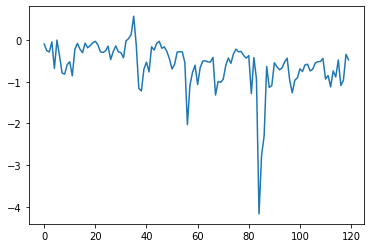

In [18]:
plt.plot([x[1]-x[0] for x in outputs])

#


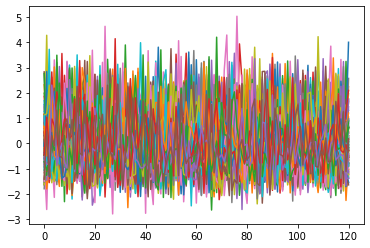

#


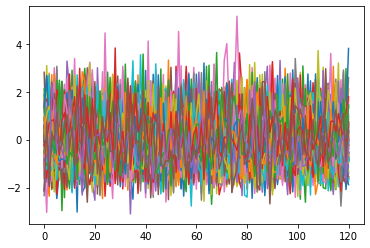

#


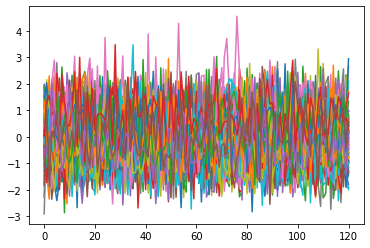

In [19]:
inp = [m5i,m15i, h1i, h4i, d1i, np.array(current_position).reshape(1,1)]

names = ["transformer_block","transformer_block_1","transformer_block_2"]
for name in names:
    for i in model.layers[10:]:
        if i.name == name:
            print("#")
            m = tf.keras.Model(inputs = model.inputs[0], outputs = i.output)
            #m.summary()
            out = m(inp[0])

    for i in range(96):
        plt.plot(np.array(out[0]).T[i])
    plt.show()

In [13]:
for i in model.layers:
    print(i.name)

input_1
tf.__operators__.getitem
reshape
conv2d
concatenate
dense
tf.compat.v1.transpose
tf.__operators__.getitem_1
reshape_1
reshape_2
dense_1
leaky_re_lu
dense_2
dense_3
layer_normalization
position_embedding
transformer_block
transformer_block_1
transformer_block_2
dense_4
dense_5
input_2
tf.__operators__.getitem_2
gru
reshape_3
dense_12
dense_13
tf.compat.v1.transpose_1
tf.__operators__.getitem_3
dense_14
reshape_4
reshape_5
dense_15
input_3
tf.__operators__.getitem_4
reshape_6
dense_16
dense_17
tf.compat.v1.transpose_2
tf.__operators__.getitem_5
dense_18
reshape_7
reshape_8
dense_19
input_4
tf.__operators__.getitem_6
reshape_9
dense_20
dense_21
tf.compat.v1.transpose_3
tf.__operators__.getitem_7
dense_22
reshape_10
reshape_11
dense_23
input_5
tf.__operators__.getitem_8
reshape_12
dense_24
dense_25
tf.compat.v1.transpose_4
tf.__operators__.getitem_9
dense_26
reshape_13
reshape_14
dense_27
dense_28
dense_29
dense_30
dense_31
input_6
dense_32
dense_33
dense_34
dense_35
